# HW1 1 313511068

## Part 1 N gram

In [67]:
from collections import defaultdict
from tqdm import tqdm
from rich import print
import psutil
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
def display_ram_usage():
    """获取并显示当前的内存使用情况。"""
    ram = psutil.virtual_memory()
    total_ram = ram.total / (1024 ** 3)  # 总内存 (GB)
    used_ram = ram.used / (1024 ** 3)    # 已用内存 (GB)
    percentage_used = ram.percent  # 已用内存百分比
    return total_ram, used_ram, percentage_used

In [69]:

class N_grams:
    def __init__(self,n:int):
        self._n = n + 1
        self._model = defaultdict(lambda: defaultdict(int))
        return 
    
    def _generate_n_grams(self, text:str)->list[str]:
        tokens = list(text.split(" "))
        n_grams = [tokens[i:i+self._n] for i in range(len(tokens) - self._n + 1)]
        return n_grams 
    
    def train(self, corpus_list:list[str]):
        for corpus in tqdm(corpus_list,desc="Training",unit="line", dynamic_ncols=True, leave=True):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:    
                prefix = tuple(ngram[:-1])
                next_word = ngram[-1]
                
                self._model[prefix][next_word] += 1
        return 
    
    def predict(self, prefix:list[str]):
        if tuple(prefix) not in self._model:
            return None
        prefix_key = tuple(prefix)
        next_word = max(self._model[prefix_key], key=self._model[prefix_key].get)
        
        return next_word

    def predict_all(self, prefix:list[str], num:int)-> list[str]:
        res = prefix
        n = self._n - 1
        for _ in range(num):
            res.append(self.predict(res[-n:]))
        
        return res
    
    def test_model(self, corpus_list:list[str] , output_file_name:str)-> dict:
        total_predictions = 0
        correct_predictions = 0
        
        data = {"Acc(%)":[] , "Ram Usage(%)":[]}
        
        # Generate n-grams from test corpus and predict next words
        for corpus in tqdm(corpus_list, desc="Testing",unit="line", dynamic_ncols=True, leave=True):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:
                prefix = ngram[:-1]  # (n-1)-gram前缀
                actual_next_word = ngram[-1]  # 真实的下一个词
                
                predicted_next_word = self.predict(prefix)
                
                if predicted_next_word == actual_next_word:
                    correct_predictions += 1
                
                total_predictions += 1
                
            total_ram, used_ram, percentage_used = display_ram_usage()
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
            # 更新进度条的后缀
            
            data["Ram Usage(%)"].append(percentage_used)
            data["Acc(%)"].append(accuracy * 100)
                

                
        df = pd.DataFrame(data)

        # Step 2: Plot the data using pandas DataFrame's plot method
        ax = df.plot()

        # Step 3: Customize the plot
        ax.set_title(f'{self._n -1} gram memory usage and acc')
        ax.set_xlabel('index')
        ax.set_ylabel('%')
        ax.grid(True)

        # Step 4: Save the plot as an image file
        plt.savefig(output_file_name, dpi=300, bbox_inches='tight')  # Save the figure
        
        # Calculate accuracy
        
        return data

## Load data

In [70]:
with open("./train.txt" , mode="r") as f_train, open("./test.txt", mode="r") as f_test:
    train_data = [line.strip() for line in f_train.readlines()]
    test_data =  [line.strip() for line in f_test.readlines()]
    

## Build model

In [71]:
model_2 = N_grams(2)

In [72]:
model_3 = N_grams(3)

In [73]:
model_2.train(train_data)

Training: 100%|██████████| 2599668/2599668 [00:10<00:00, 239971.82line/s]


In [74]:
model_3.train(train_data)

Training:   0%|          | 0/2599668 [00:00<?, ?line/s]

Training: 100%|██████████| 2599668/2599668 [00:12<00:00, 208881.30line/s]


Testing: 100%|██████████| 649918/649918 [01:41<00:00, 6386.98line/s]


35.71754738420279

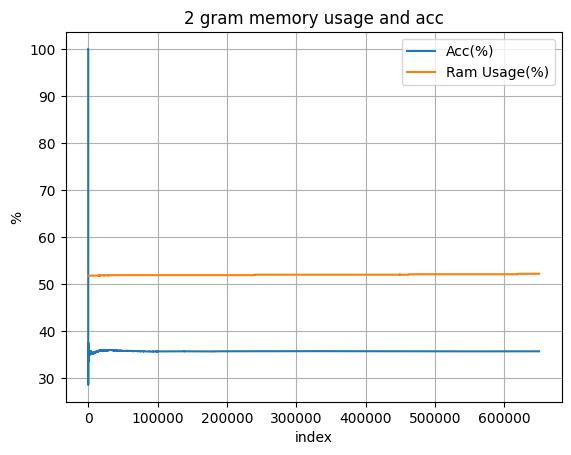

In [9]:
res_2 = model_2.test_model(test_data, output_file_name="res2.png")
print(res_2["Acc(%)"][-1])

Testing: 100%|██████████| 649918/649918 [00:38<00:00, 16666.52line/s]


36.58432955673828

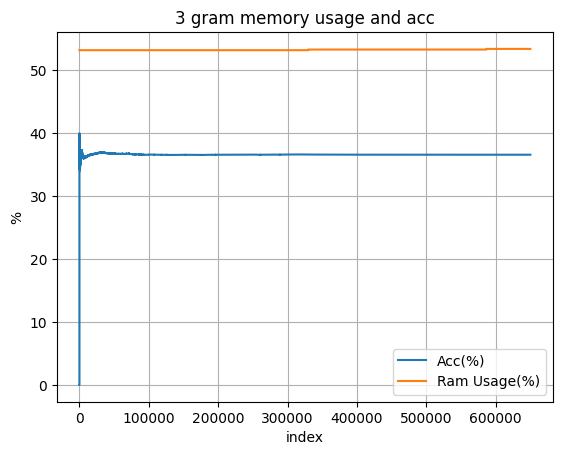

In [10]:
res_3 = model_3.test_model(test_data, output_file_name="res3.png")
print(res_3["Acc(%)"][-1])

## incomplete 

In [75]:
with open("./incomplete.txt", mode="r") as f:
    data = [line.strip() for line in f.readlines()]

In [83]:
res = [model_2.predict_all(item.split(" "), num=20) for item in data]
res = [' '.join(item ) for item in res]
print(res)

[
    'cover with foil and bake for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'roll up and place in a large bowl and mix well and set aside to cool completely on wire rack to cool',
    'cook the pasta and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'stir in the center of the pan and bake for about 5 minutes or until the mixture into the pan and bake',
    'spread out on a baking sheet and bake for about 5 minutes or until the mixture into the pan and bake for',
    'transfer the mixture into the pan and bake for about 5 minutes or until the mixture into the pan and bake 
for',
    'put the chicken and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'push the dough into a large bowl and mix well and set aside to cool completely on wire rack to cool 
completely',
    'cut into squares and serve with a fork and serve with a fork and serve with a fork and serve with a',
    'toss the salad and toss to coat the bottom of the pan and bake for about 5 minutes or until the mixture'
]

## Part 2 RNN

In [3]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import loggers as pl_loggers
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from lightning.pytorch.callbacks import ModelCheckpoint
import re
from collections import defaultdict, Counter

In [4]:
@dataclass
class Lib:
    word2idx: dict[str,int]
    idx2word: dict[int,str]
    size : int
    
    def word_2_index(self, word:str)->int:
        return self.word2idx.get(word, self.word2idx[" "])
    
    def index_2_word(self, index:int)->str:
        return self.idx2word.get(index, " ")
    
    @staticmethod
    def natural_split(text:str, no_symbol:bool=True)->list[str]:
        pattern = r"([a-zA-Z0-9]+|[^\s\w]|[\s]+)" if not no_symbol else r"[a-zA-Z0-9]+"
        result = re.findall(pattern, text)
        return result
    
    @classmethod
    def build_from_text(cls, str_list:list[str]):
        group = ' '.join(str_list)
        vocab = set(Lib.natural_split(group, False))
        
        word2idx = {word: i for i,word in enumerate(vocab)}
        idx2word = {idx : word for word, idx in word2idx.items()}
        
        return cls(word2idx, idx2word, len(word2idx))
    
    @classmethod
    def build_from_file(cls, filename:str):
        with open(filename, "r") as f:
            data = [item.strip() for item in f.readlines()]
        return cls.build_from_text(data)
    
    def sentence_to_idx_tensor(self, sentence:list[str]):
        return torch.tensor([self.word_2_index(word) for word in sentence], dtype=torch.long)
    
    
    def word_to_tensor(self, word:str)->torch.Tensor:
        tensor = torch.zeros(self.size)
        index = self.word_2_index(word)
        
        tensor[index] = 1
        return tensor  
    
    def tensor_to_sentence(self, tensor:torch.Tensor) ->str:
        return ' '.join([self.index_2_word(int(item)) for item in tensor])
    
    def __len__(self) -> int:
        return self.size

## Build a dataset

In [18]:
class TextDataset(Dataset):
    def __init__(self, sentences:str, n_list:int, text_lib:Lib, train_mode:bool=True):
        self.n_list = n_list
        self.text_lib = text_lib
        self.data = TextDataset.process_data(sentences, n_list, train_mode)
        return 
    
    @staticmethod
    def gen_process_data(sentences:str,n_list:list[int]):
        for n in n_list:
            for sentence in tqdm(sentences, desc="process", unit="line", dynamic_ncols=True, leave=True):
                line = Lib.natural_split(sentence)
                for i in range(len(line) - n):
                    input_str = line[i:i+n]
                    target_str = line[i+n]
                    
                    yield tuple(input_str), target_str
    
    @staticmethod
    def process_data( sentences:str,n_list:list[int], train_mode:bool):
        if not train_mode:
            data = [
                (input_str, target_str) 
                for input_str, target_str in TextDataset.gen_process_data(sentences, n_list)
            ]
            return data
        
        # train mode
        data_dict = defaultdict(list)
        
        for input_str, target_str in TextDataset.gen_process_data(sentences, n_list):
            k , v = input_str, target_str
                
            data_dict[k].append(v)
                
        for k in tqdm(data_dict.keys(), desc="counting", unit="pair", dynamic_ncols=True, leave=True):
            large_word = Counter(data_dict[k]).most_common(1)
            data_dict[k] = large_word[0][0]
        
        return list(data_dict.items())
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int)-> tuple[torch.Tensor, torch.Tensor]:
        input_str, target_str = self.data[index]
        input_tensor  = self.text_lib.sentence_to_idx_tensor(input_str)
        target_tensor = self.text_lib.word_to_tensor(target_str)
        return input_tensor, target_tensor
    
    @classmethod
    def build_from_file(cls, filename:str,n_list:int, lib: Lib = None, train_mode:bool=False):
        with open(file=filename, mode="r") as f:
            data = [line.strip() for line in f.readlines()]
            
        if lib is None:
            lib = Lib.build_from_text(data)
            
        return cls(data, n_list, lib, train_mode) 

## RNN Model


In [12]:
class RnnModel(L.LightningModule):
    def __init__(self,vocab_size:int, embedding_dim:int, hidden_size:int, output_size:int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        return 
    
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        out = F.softmax(out, dim=1)
        return out
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self,train_batch, batch_idx):
        
        input_tensor, target_tensor = train_batch
        
        output = self.forward(input_tensor)
        loss = F.cross_entropy(input=output,target=target_tensor)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        predicted_tensor, target_tensor_idx = torch.argmax(output, dim=1), torch.argmax(target_tensor, dim=1)
        accuracy = (predicted_tensor == target_tensor_idx).float().mean()
        
        self.log('tran_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        
        input_tensor, target_tensor = val_batch
        
        output = self.forward(input_tensor)
        loss = F.cross_entropy(input=output,target=target_tensor)
        self.log("test_loss",  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        predicted_tensor, target_tensor_idx = torch.argmax(output, dim=1), torch.argmax(target_tensor, dim=1)
        accuracy = (predicted_tensor == target_tensor_idx).float().mean()
        
        self.log('test_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

In [13]:
epoch = 10
batch_size = 32
number_of_layer = 2
hidden=128
embedding_dim = 256
prefix_len = [2,3,4]

In [6]:
lib = Lib.build_from_file("./train.txt")

In [92]:
model = RnnModel(
    vocab_size=lib.size,
    embedding_dim=embedding_dim,
    hidden_size=hidden,
    output_size=lib.size,
    num_layers=number_of_layer,
)

In [93]:
print(model)

RnnModel(
  (embedding): Embedding(38409, 256)
  (rnn): RNN(256, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=38409, bias=True)
)


In [80]:
tb_logger = pl_loggers.TensorBoardLogger("logs/")

In [81]:
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    dirpath='checkpoints',
    filename='model-{epoch:02d}-{train_loss:.2f}',
    save_top_k=3,
    mode='min'
)

In [82]:
trainer = L.Trainer(
    callbacks=[checkpoint_callback],
    accelerator="gpu",
    logger=tb_logger, 
    default_root_dir="out/", 
    max_epochs=epoch,
    # progress_bar_refresh_rate=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [96]:
train_dataset = TextDataset.build_from_file("./train.txt",n_list=prefix_len,lib=lib,train_mode=True)

counting: 100%|██████████| 5898597/5898597 [00:15<00:00, 380462.95pair/s]


In [98]:
len(train_dataset)

5898597

In [19]:
test_dataset = TextDataset.build_from_file("./test.txt",n_list=[4],lib=lib, train_mode=False)

process: 100%|██████████| 649918/649918 [00:01<00:00, 348634.50line/s]


In [20]:
len(test_dataset)

2050386

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [32]:
test_dataloader = DataLoader(test_dataset, batch_size=5000, shuffle=True)

In [ ]:
trainer.fit(model, train_dataloader,test_dataloader,ckpt_path="last")

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 8.1 M  | train
1 | rnn       | RNN       | 66.0 K | train
2 | fc        | Linear    | 8.1 M  | train
------------------------------------------------
16.3 M    Trainable params
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 389838/389838 [1:06:06<00:00, 98.29it/s, v_num=1, train_loss_step=10.90, tran_acc_step=0.160] 

In [7]:
df_loss = pd.read_csv("./logs_csv/lightning_logs_version_10_loss.csv")
df_loss = df_loss.rename(columns={"Value":"Training Loss"})
df_loss

,Wall time,Step,Training Loss
0,1.729773e+09,393,10.473721
1,1.729774e+09,787,10.449966
2,1.729774e+09,1181,10.448833
3,1.729774e+09,1575,10.448231
4,1.729775e+09,1969,10.447832
5,1.729775e+09,2363,10.447613
6,1.729776e+09,2757,10.447351
7,1.729776e+09,3151,10.447287
8,1.729777e+09,3545,10.447032
9,1.729777e+09,3939,10.446907


<Axes: title={'center': 'Training loss'}, xlabel='epoch', ylabel='loss'>

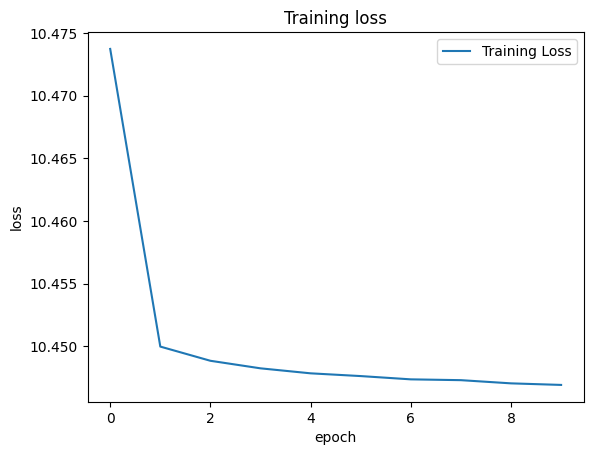

In [8]:
df_loss.plot(y="Training Loss",title="Training loss", ylabel="loss", xlabel="epoch")

In [9]:
df_acc = pd.read_csv("./logs_csv/lightning_logs_version_10_acc.csv")
df_acc = df_acc.rename(columns={"Value":"Training Acc"})
df_acc

,Wall time,Step,Training Acc
0,1.729773e+09,393,0.087443
1,1.729774e+09,787,0.106210
2,1.729774e+09,1181,0.107308
3,1.729774e+09,1575,0.107887
4,1.729775e+09,1969,0.108285
5,1.729775e+09,2363,0.108494
6,1.729776e+09,2757,0.108740
7,1.729776e+09,3151,0.108811
8,1.729777e+09,3545,0.109061
9,1.729777e+09,3939,0.109200


<Axes: title={'center': 'Training acc'}, xlabel='epoch', ylabel='acc'>

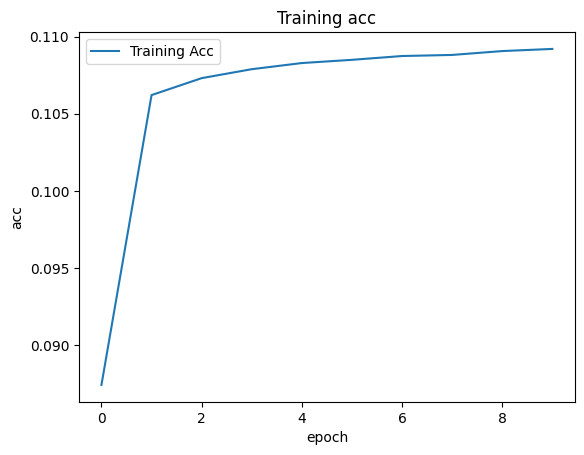

In [10]:
df_acc.plot(y="Training Acc",title="Training acc", ylabel="acc", xlabel="epoch")

## Check Rnn model in test acc

In [14]:
model_load = RnnModel.load_from_checkpoint(
    "./checkpoints/model-epoch=09-train_loss=10.45.ckpt",
    vocab_size=lib.size,
    embedding_dim=embedding_dim,
    hidden_size=hidden,
    output_size=lib.size,
    num_layers=number_of_layer,
)
print(model_load)

RnnModel(
  (embedding): Embedding(38409, 256)
  (rnn): RNN(256, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=38409, bias=True)
)


In [15]:
def test_model_acc(model: RnnModel, dataloader: DataLoader) -> float:
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  # 禁用梯度计算
        for input_tensor, target_tensor in tqdm(dataloader, desc="Testing", unit="batch"):
            input_tensor, target_tensor = input_tensor.to(model.device), target_tensor.to(model.device)
            
            outputs = model(input_tensor)
            
            predicted = torch.argmax(outputs, dim=1)
            target = torch.argmax(target_tensor, dim=1)
            
            total += target.size(0)
            
            correct += (predicted == target).sum().item()
    
    accuracy = correct / total
    return accuracy

In [21]:
test_dataloader_plus = DataLoader(test_dataset, batch_size=5000)

In [22]:
test_acc = test_model_acc(model=model_load, dataloader=test_dataloader_plus)
print(test_acc)

Testing: 100%|██████████| 411/411 [03:28<00:00,  1.97batch/s]

0.0


In [23]:
with open("./incomplete.txt", mode="r") as f:
    data = [line.strip() for line in f.readlines()]
print(data)

['cover with', 'roll up', 'cook the', 'stir in', 'spread out', 'transfer the', 'put the', 'push the', 'cut into', 'toss the']


In [37]:
def complete_string(prefix_list:list[str], lib:Lib, model:RnnModel, model_prefix:int, num:int)->str:
    # prefix_list = []
    
    # # fill the empty space
    # for prefix in prefix_list:
    #     line = prefix.split(" ")
        
    #     if len(line) < model_prefix:
    #         line = [" " for _ in range(model_prefix-len(line))] + line    
        
    #     prefix_list.append(line)
    
    
    tensor_list = torch.stack([
        torch.cat([
            lib.sentence_to_idx_tensor(prefix.split(" "))
        ])
        for prefix in prefix_list
    ]).to(model.device) 
    
    print(tensor_list)
    
    for _ in range(num):
        # get last 2 column        
        if tensor_list.shape[1] < model_prefix:
            input_tensor = tensor_list
        else:
            input_tensor = tensor_list[:, -model_prefix:]

        output_tensor = model(input_tensor)
        output_idx = torch.argmax(output_tensor, dim=1)
        
        output_idx = output_idx.unsqueeze(-1)
        tensor_list = torch.cat((tensor_list, output_idx), dim=1)
    
    print(tensor_list)
    output = [lib.tensor_to_sentence(row) for row in tensor_list]
    return output

In [38]:
output = complete_string(data, lib=lib, model=model_load, model_prefix=4, num=20)

tensor([[ 3129,  1790],
        [ 8441, 17556],
        [38094,  3349],
        [32705, 15555],
        [26674, 28770],
        [15341,  3349],
        [  975,  3349],
        [17047,  3349],
        [ 9765, 34084],
        [26491,  3349]], device='cuda:0')
tensor([[ 3129,  1790, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774,
         29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774,
         29555, 29774],
        [ 8441, 17556, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555,
         29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555,
         29774, 29555],
        [38094,  3349, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774,
         29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774,
         29555, 29774],
        [32705, 15555, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555,
         29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555, 29774, 29555,
         29774, 29555],
        [26674

In [39]:
output

['cover with cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas',
 'roll up halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito',
 'cook the cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas',
 'stir in halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito',
 'spread out cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas',
 'transfer the cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrito halacas cabrit